# Trabalho Final

Importando as bibliotecas que serão usadas

In [1]:
# Util
import operator
import math
import random
import numpy as np
from numpy import linspace, sin, pi, int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import librosa
import librosa.display
from IPython.display import Audio

import warnings; warnings.simplefilter('ignore')

Carregando o som desejado

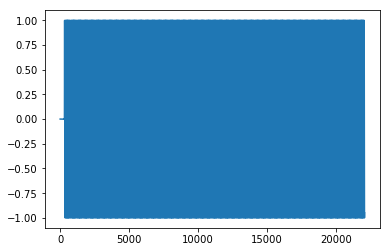

In [2]:
f0 = 440.0
target, sr = librosa.load('SOUNDS/au_sample.wav')
#target, sr = librosa.load('SOUNDS/flute.wav')
#target, sr = librosa.load('SOUNDS/harp.wav')
#target, sr = librosa.load('SOUNDS/string.wav')
target = librosa.util.normalize(target[:sr]) # normalizando etruncando para 1 segundo
duration = 1.0
plt.plot(target)
Audio(target,rate=sr)

In [3]:
# FUNCOES OPERADORES
def note(freq, amp=1.0):
    t = linspace(0,1.0,1.0*22050)
    data = sin(2.0*pi*freq*t)*amp
    return data

def fm(c_amp,c_freq, note_mod):
    t = linspace(0,1.0,1.0*22050)
    data = c_amp * sin(2.0*pi *(c_freq*t + note_mod))
    return data


In [4]:
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = librosa.util.normalize(np.abs(librosa.stft(candidate)), axis=1)
    candidate_pha = librosa.util.normalize(np.angle(librosa.stft(candidate)), axis=1)
    
    target_mag = librosa.util.normalize(np.abs(librosa.stft(target)), axis=1)
    target_pha = librosa.util.normalize(np.angle(librosa.stft(target)), axis=1)
    
    mag_error = np.mean((candidate_mag - target_mag)**2)
    pha_error = np.mean((candidate_pha - target_pha)**2)
    
    return mag_error*0.7 + pha_error*0.3,

In [5]:
def evaluate_max(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = np.abs(librosa.stft(candidate))
    candidate_pha = np.angle(librosa.stft(candidate))
    
    target_mag = np.abs(librosa.stft(target))
    target_pha = np.angle(librosa.stft(target))
    
    mag_error = np.max((candidate_mag - target_mag)**2)
    pha_error = np.max((candidate_pha - target_pha)**2)
    
    return (mag_error*0.7 + pha_error*0.3),

In [6]:
# PROGRAMAÇÂO GENETICA
pset = gp.PrimitiveSetTyped("MAIN", [float], np.ndarray, "F")

# OPERATORS
pset.addPrimitive(note, [float, float], np.ndarray)
pset.addPrimitive(operator.add,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.mul,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(fm, [float,float,np.ndarray], np.ndarray)
pset.addPrimitive(operator.add,[float,float],float)
# pset.addPrimitive(gen_cos, [float,float], list)

# TERMINALS
# if not scoop.IS_ORIGIN:
#    pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1), float)
pset.addTerminal(note(0), np.ndarray, 'zero')
pset.addTerminal(note(f0), np.ndarray, 'fundamental')
pset.addTerminal(note(2*f0), np.ndarray, 'harm1')
pset.addTerminal(note(3*f0), np.ndarray, 'harm2')
pset.addTerminal(note(4*f0), np.ndarray, 'harm3')
pset.addTerminal(f0, float)
pset.addTerminal(2*f0, float)
pset.addTerminal(3*f0, float)
pset.addTerminal(4*f0, float)

# CONFIG
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("map", futures.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evaluate_max)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [7]:
def main():
    random.seed(10)
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, 0.75, 0.2, 100, stats, halloffame=hof)

    return pop, stats, hof

In [8]:
pop, stats, hof = main()

gen	nevals	avg   	std    	min  	max   
0  	20000 	171673	93710.3	23880	731725
1  	15845 	146124	62871.7	23880	730523
2  	15968 	131937	60193.4	23880	732900
3  	16019 	123061	62006.3	23880	732838
4  	16041 	115757	60039.5	22312.3	732597
5  	16053 	112155	63290.5	22312.3	724955
6  	16091 	109413	62648.1	22312.3	733346
7  	15984 	107656	61663.3	22312.3	724955
8  	15973 	106154	64133.7	22312.3	730762
9  	15892 	103159	63749.6	22149.5	724955
10 	15853 	101280	63504.2	22111.6	724955
11 	16136 	99391.2	62782.9	22149.5	724955
12 	15954 	96566.6	64372.4	22312.3	730885
13 	15982 	94471.5	62634.7	22312.3	724955
14 	16042 	91217.7	61104.9	22177.8	724955
15 	15945 	89002  	61356.7	22043.4	724955
16 	15983 	85901.6	61600.2	22043.4	724955
17 	15971 	82642.7	61049.9	21951.7	724955
18 	16069 	80049.6	60699  	21903.2	724955
19 	16020 	76171.8	61469.3	21903.2	724955
20 	15952 	71621.1	61740.4	21903.2	724955
21 	16037 	66856.7	59960.2	21889.9	724955
22 	16058 	62799.4	58828.2	21889.9	724955
23 	15997 	596

In [9]:
str(hof[0])

'add(add(mul(add(note(440.0, 1760.0), add(add(add(note(add(880.0, 1320.0), 95.36098416925654), add(mul(fm(440.0, 0, harm1), add(fundamental, fundamental)), add(add(fundamental, fundamental), fundamental))), harm2), note(1320.0, 1320.0))), harm1), mul(harm2, add(add(add(harm1, add(fm(95.90845141407797, 0, harm1), zero)), mul(note(1320.0, add(440.0, add(1320.0, 440.0))), mul(zero, add(note(F0, add(1760.0, 440.0)), add(fm(880.0, 440.0, harm3), add(harm3, harm3)))))), harm1))), add(mul(add(harm2, mul(fundamental, harm1)), note(1760.0, 880.0)), fm(2.80203841879767, add(add(add(18.553752299490355, -1), 1320.0), add(440.0, 880.0)), add(fundamental, zero))))'

In [10]:
func = toolbox.compile(hof[0])
candidate = librosa.util.normalize(func(f0))
Audio(candidate,rate=sr)

In [11]:
librosa.output.write_wav('SOUNDS/gen_au_sample2.wav',candidate,sr)

In [12]:
def print_signals(target,candidate):
    plt.figure(1,figsize=(15, 9))
    plt.subplot(221)
    plt.plot(target)
    
    plt.subplot(222)
    plt.plot(candidate)
    
    plt.subplot(223)
    D_target = librosa.amplitude_to_db(librosa.stft(target), ref=np.max)
    librosa.display.specshow(D_target, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('TARGET')
    
    plt.subplot(224)
    D_candidate = librosa.amplitude_to_db(librosa.stft(candidate), ref=np.max)
    librosa.display.specshow(D_candidate, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CANDIDATE')

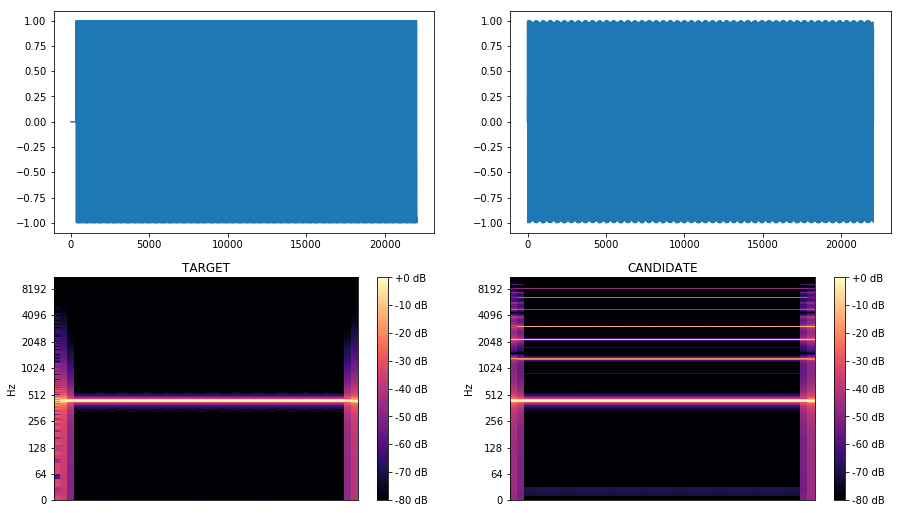

In [13]:
print_signals(target,candidate)